# Poverty Mapping for Impact Evaluation of PPPP &ndash; A Computer Vision and Machine Learning Approach

In [176]:
import os
import time
from tempfile import TemporaryDirectory
import itertools
import pickle
from pathlib import Path
from typing import Union

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import geopandas as gpd
from PIL import Image
import rasterio

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torchvision.models.feature_extraction import create_feature_extractor
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
from transformers import AutoImageProcessor, ConvNextV2Model
from tqdm import tqdm
import timm

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA

import xgboost as xgb

## Table of Contents

1. [Overview](#Overview)
2. [Approach](#Approach)
    1. [Data](#Data)
    2. [Model Building](#Model-Building)
    3. [Notebook Organization](#Notebook-Organization)
4. [Helpers](#Helpers)
5. [Model Training](#Model-Training)
    1. [Pure ViT Model](#Pure-ViT-Model)
    2. [ViT Feature Extractor + XGBoost](#ViT-Feature-Extractor-+-XGBoost)
    3. [ViT (Nightlight Trained) Feature Extractor + XGBoost](#ViT-(Nightlight-Trained)-Feature-Extractor-+-XGBoost)
6. [Analysis](#Analysis)

## Overview

Geographical data from satellite imagery and other mapping sources are rich in information, making them invaluable for predictive modeling and mapping. One notable use case of such data is the prediction of wealth and poverty levels, which can simplify data collection processes and enable faster policy evaluation and implementation. Notably, [ThinkingMachines](https://thinkingmachin.es/) has developed open-source machine learning codes for such analyses. For predicting poverty levels in the Philippines, they explored following approaches:

1. Computer vision model trained on [satellite images trained on nighlight](https://github.com/thinkingmachines/ph-poverty-mapping/tree/master);
2. Machine Learning models trained on [geodata including of nightlight value, OpenStreetMap (OSM street features), and mobile and internet speeds](https://github.com/thinkingmachines/unicef-ai4d-poverty-mapping)

__In this project, we adopt, expand, and explore this methodology for poverty mapping as a means to evaluating public policy effectiveness__.

Here, we focus on the assessment of the Pantawid Pamilyang Program Pilipino (PPPP), a flagship program of the Philippine government to address the poverty situation in the country. The PPPP is conditional cash transfer (CCT) program in the Philippines aimed at reducing poverty and promoting human capital development. It provides financial assistance to low-income families, especially those with children, to help improve their health, nutrition, and education. An effective and quick poverty mapping approach will allow quicker detection of worsening living conditions and ensure a more equitable distribution of resources.

Please refer to `requirements.txt` for the installation requirements.

## Approach

### Data

This project makes use of __Geo-Temporal data__ including:
- _Geographical boundaries_ - of regions, provinces, and municipalities
- _PPPP data_ - Number of households enrolled in the program
- _Wealth index_ - Wealth information from surveys representing ground truth for training
- _Poverty incidence and population density_ - Number of households living under the poverty line
- _Satellite data_ - Day time satellite images and nightlight values
- _Physical features and amenities_ - Proximity to schools, markets, roads, etc
- _Internet and mobile data usage_
    
As the data collected is diverse in nature, a substantial proportion of the work is focused on __data cleaning__:
- _PDF tables_ - reconciling data extracted from tables in PDF reports (i.e. PPPP data), with differences arising from inconsistent formatting and alignment issues
- _Data from different sources_ - reconciling data with different naming conventions and data organization
- _Geodata_ - reconciling different geodata which may have different resolutions, geoboundaries and file types

### Model Building

Multiple models are built on different combinations of features, and compared to identify the best model for the current purpose.

Specifically, the models are built to:

- __Predict__: the _wealth index_ obtained from the [Demographic and Health Survey (DHS)](https://dhsprogram.com/)

- Using __features__ including: _daytime satellite images, nightlight, proximity to amenities, internet speed, and mobile data usage_


As DHS surveys are costly and time-consuming, they cover only selected locations, not the entire country. Therein lies the utility of such a predictive model, which can predict the wealth index (i.e. poverty levels) for any degree of geographic coverage.

### Notebook Organization

The work is presented in three notebooks in this repository:

1. `data_pppp_PI_geobounds.ipynb` - This notebook produces the geographical distribution of enrolled PPPP households, normalized by the estimated population living under the poverty line. In short, it gives the 'PPPP effort' relative to the amount of poverty at a given location. The PPPP data, i.e. number of households enrolled PPPP, is extracted from tables spread across multiple PDF reports. Other data gathered here includes geographical boundaries, population density, and poverty incidence.

2. `data_sat_img_map_feat.ipynb` - This notebook compiles the data needed for model training and prediction. This includes the wealth index to be predicted, and the various features used for prediction. The process relies heavily on ThinkingMachines open source codes to systematically collect most of the required data, and QGIS for cloudfree daytime satellite images.

3. `poverty_mapping_pppp.ipynb` - This is the current notebook. This notebook focuses on building the model using the data gathered in `data_sat_img_map_feat.ipynb` above. The poverty levels for the entire country from 2020 to 2023 is mapped using the final model here. The mapped poverty values are analysed in the context of the 'PPPP effort' derived from `data_pppp_PI_geobounds.ipynb` above, to assess the effectiveness of the PPPP in alleviating poverty.

## Helpers

In [2]:
# Custom Dataset class
class RegressionDataset2(Dataset):
    def __init__(self, image_folder, targets_df=None, transform=None,is_train=True):
        self.image_folder = image_folder
        self.targets_df = targets_df
        self.transform = transform
        self.image_files = targets_df['filename'].tolist()
        self.is_train = is_train
        if self.is_train:        
            self.targets = targets_df['target']
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        if self.is_train:
            target = self.targets[idx]
        
        if self.transform:
            image = self.transform(image)
        
        if self.is_train:
            return image, target
        else:
            return image

## Model Training

With the above in mind, we explore three modeling approaches:
1. Pure ViT Model - A complete deep learning model receiving satellite images and other features (e.g. OOKLA, OSM) as input;
2. ViT feature extractor with XGBoost - Using ViT for feature extraction from daytime satellite images, used for training an XGBoost model alongside other features; and
3. ViT trained on nightlight as feature extractor with XGBoost - Using ViT further trained on nightlights for feature extraction from daytime satellite images, used for training an XGBoost model alongside other features

### Pure ViT Model

A preliminary comparison of different deep learning computer vision models was performed, considering pre-trained models such as ViT, ConvMixer, and ResNet. Variants of such models further trained on multi-band S2 Sentinel satellite imagery were also explored. Initial assessment indicates that the ViT model provides superior predictions for the satellite images used here (Assessment omitted from notebook for simplicity). Therefore, we use the pre-trained ViT model in the current project.

First, we load the previously extracted target values from `y.csv` and features from `X.csv` (refer to `data_sat_img_map_feat.ipynb`).

In [38]:
# Load data
data_path = 'data'
df_y_raw = pd.read_csv(os.path.join(data_path,'y.csv'))\
    .rename(columns={'Wealth_Index':'target'})
df_y_raw['filename'] = df_y_raw['DHSCLUST'].map(lambda x: 'map_'+str(x-1)+'.tif')
df_y_raw.drop(columns='DHSCLUST', inplace=True)
df_y_raw = df_y_raw.astype({'target':'float32'})

df_X_raw = pd.read_csv(os.path.join(data_path,'X.csv'))
df_X_raw.drop(columns=['DHSCLUST'],inplace=True)
df_raw = pd.concat([df_X_raw,df_y_raw],axis=1)
df_raw.dropna(inplace=True)

We perform train-test split and get the train, validation, and test indices, following by MinMaxScaling of the target values, as recommended by ThinkingMachines. The target values therefore ranges from 0 to 1.

In [39]:
# Perform train test split
ind_training, ind_test = train_test_split(df_raw.index, test_size=0.2, random_state=42)
ind_train, ind_val = train_test_split(ind_training, test_size=0.2, random_state=42)

# Load the full dataset
df = df_raw.copy()
image_folder = 'data/daysat/2022/'

# MinMaxScale to target
scaler = MinMaxScaler()
df.loc[ind_train.union(ind_val),'target'] = scaler.fit_transform(df.loc[ind_train.union(ind_val),['target']])
df.loc[ind_test,'target'] = scaler.transform(df.loc[ind_test,['target']])

We define the Neural Network (NN) for regression architecture, using the pretrained ViT model for the daytime satellite images, and a Fully-Connected (FC) layer for the tabular data. A fusion layer then combines the two input types, running through FC layers with a final sigmoid activation. We also define a custom dataset object to allow a combination of images and tabular data to be fed into the NN.

In [2]:
class VitBaseForRegression3(nn.Module):
    def __init__(self, img_model, tabular_input_dim):
        super(VitBaseForRegression3, self).__init__()
        
        self.backbone = img_model
        
        # Tabular data processing network with Batch Normalization
        self.tabular_net = nn.Sequential(
            nn.BatchNorm1d(tabular_input_dim),  # BatchNorm layer for tabular data
            nn.Linear(tabular_input_dim, 256),
            nn.BatchNorm1d(256),    # BatchNorm after first linear layer
            nn.ReLU(),
        )
        
        # Final regression layer after feature fusion with Batch Normalization
        self.fusion_layer = nn.Sequential(
            nn.BatchNorm1d(self.backbone.num_features + 256),  # BatchNorm layer for tabular data
            nn.Linear(self.backbone.num_features + 256, 256),
            nn.BatchNorm1d(256),     # BatchNorm after second linear layer
            nn.ReLU(),
            nn.Dropout(0.5),        # Dropout with a 50% drop probability            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),     # BatchNorm after second linear layer
            nn.ReLU(),
            nn.Dropout(0.5),        # Dropout with a 50% drop probability
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),     # BatchNorm after third linear layer
            nn.ReLU(),
            nn.Dropout(0.5),         # Dropout with a 50% drop probability
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),     # BatchNorm after third linear layer
            nn.ReLU(),
            nn.Dropout(0.5),         # Dropout with a 50% drop probability
            nn.Linear(32, 1),
            nn.Sigmoid()            # Activation function
        )
        
        # Optionally, freeze the weights of the ViT backbone
        for param in self.backbone.parameters():
            param.requires_grad = False
            
    def forward(self, images, tabular_data):
        # Extract image features from ViT
        features = self.backbone(images)

        # Process tabular data
        tabular_features = self.tabular_net(tabular_data)
        
        # Concatenate image and tabular features
        combined_features = torch.cat((features, tabular_features), dim=1)

        # Pass combined features through the final regression layer
        outputs = self.fusion_layer(combined_features)
        
        return outputs

class RegressionDataset(Dataset):
    def __init__(self, image_folder, df, transform=None):
        self.image_folder = image_folder
        self.df = df
        self.transform = transform
        
        # Extract filenames, tabular features, and targets
        self.image_files = df['filename'].tolist()
        self.tabular_data = df.drop(columns=['filename', 'target']).values
        self.targets = df['target'].tolist()
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        
        # Get tabular data and target
        tabular_data = torch.tensor(self.tabular_data[idx], dtype=torch.float32)
        target = torch.tensor(self.targets[idx], dtype=torch.float32)
        
        if self.transform:
            image = self.transform(image)
        
        return image, tabular_data, target

The pretrained ViT model is loaded from timm, a library for PyTorch Image Models, and passed into the regression NN. Training specifics like optimizer and learning rate schedulers are defined.

In [41]:
# Load ViT model
img_model = timm.create_model(
    'vit_base_patch16_224.dino',
    pretrained=True,
    num_classes=0,  # remove classifier nn.Linear
)

# Get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(img_model)
model_transforms = timm.data.create_transform(**data_config, is_training=False)

# Create regression model
model_reg = VitBaseForRegression3(img_model,df.shape[1]-2)

# Use GPU training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_reg.to(device);

criterion = nn.MSELoss()
optimizer = optim.SGD(model_reg.parameters(), lr=0.005, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

Image augmentation is included in the transformation pipeline, ending with ViT specific transformations.

In [42]:
# transform
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),                        # Resize to 224x224
    transforms.RandomHorizontalFlip(p=0.5),               # Randomly flip horizontally with a probability of 0.5
    transforms.RandomVerticalFlip(p=0.5),                 # Randomly flip vertically with a probability of 0.5
    transforms.RandomRotation(degrees=30),                # Randomly rotate within the range [-30, 30] degrees
    transforms.RandomAffine(degrees=0, shear=10),         # Apply shearing with a range of [-10, 10] degrees
    # transforms.ToTensor(),                                # Convert the image to a tensor
    model_transforms
])

val_transform = model_transforms
test_transform = model_transforms

data_transforms = {
    'train': train_transform,
    'val': val_transform,
    'test': test_transform
}

We then create the datasets...

In [43]:
# Create datasets
train_dataset = RegressionDataset(image_folder=image_folder, df=df.loc[ind_train,:].reset_index(drop=True),transform=data_transforms['train'])
val_dataset = RegressionDataset(image_folder=image_folder, df=df.loc[ind_val,:].reset_index(drop=True),transform=data_transforms['val'])
test_dataset = RegressionDataset(image_folder=image_folder, df=df.loc[ind_test,:].reset_index(drop=True),transform=data_transforms['test'])

# Determine the sizes for the different datasets
total_size, train_val_size, train_size, val_size, test_size = len(df), len(ind_train) + len(ind_val), len(ind_train), len(ind_val), len(ind_test)
dataset_sizes = {'train':train_size, 'val':val_size, 'test': test_size}

# Create DataLoader instances
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4,drop_last=True),
    'val': DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4,drop_last=True),
    'test': DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4,drop_last=True)
}

... and define the model training process.

In [3]:
# Training code
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, verbose=0, plot_curves=True):
    since = time.time()

    df = pd.DataFrame({'train': np.zeros([num_epochs]), 'val': np.zeros([num_epochs])})
    
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_loss = 1e10

        for epoch in range(num_epochs):
            if verbose == 1:
                print(f'Epoch {epoch}/{num_epochs - 1}')
                print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0

                # Iterate over data.
                for image_inputs, tabular_inputs, labels in dataloaders[phase]:
                    image_inputs = image_inputs.to(device)
                    tabular_inputs = tabular_inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        # Pass both image and tabular data to the model
                        outputs = model(image_inputs, tabular_inputs).squeeze()
                        loss = criterion(outputs, labels.squeeze())
                        
                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * image_inputs.size(0)  # assuming batch size

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]

                if verbose == 1:
                    print(f'{phase} Loss: {epoch_loss:.4f}')
                df.loc[epoch, phase] = epoch_loss

                # deep copy the model
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                    torch.save(model.state_dict(), best_model_params_path)

            if verbose == 1:
                print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

        if plot_curves:
            df.plot()

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    
    return model, df

Training complete in 1m 2s


/tmp/ipykernel_111077/1581909940.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_params_path))


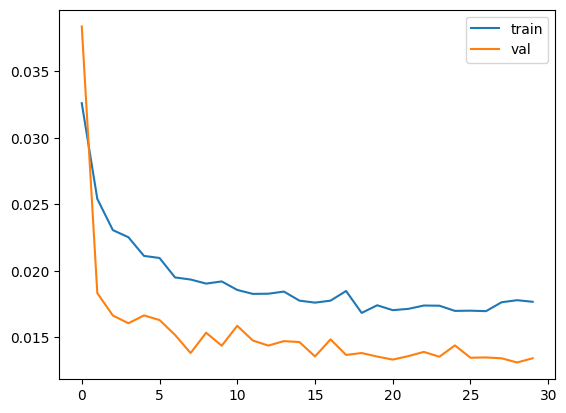

In [45]:
# Train model
model_reg, df = train_model(model_reg, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=30,verbose=0,plot_curves=True)

Taking a closer look at the training curves, we see that optimum performance is quickly reached.

(0.01, 0.04)

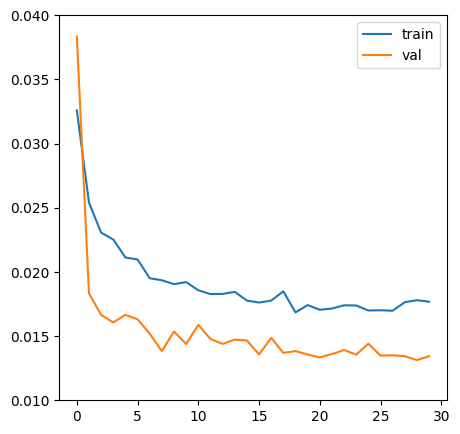

In [46]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
df.plot(ax=ax)
ax.set_ylim([0.01,0.04])

Finally, we predict on the test set and observe a mean squared error of 0.014.

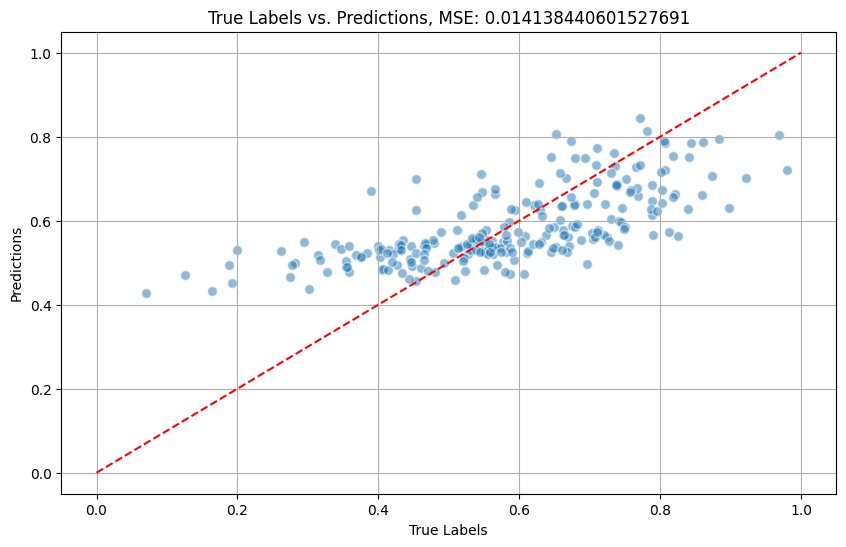

In [47]:
# Initialize lists to store the outputs and labels
all_outputs = []
all_labels = []

model_reg.eval()  # Set the model to evaluation mode

with torch.no_grad():
    for image_inputs, tabular_inputs, labels in dataloaders['test']:
        image_inputs = image_inputs.to(device)
        tabular_inputs = tabular_inputs.to(device)
        labels = labels.to(device)
        outputs = model_reg(image_inputs, tabular_inputs)

        # Collect outputs and labels
        all_outputs.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate all collected outputs and labels
all_outputs = np.concatenate(all_outputs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Plot true labels vs. predictions
plt.figure(figsize=(10, 6))
plt.scatter(all_labels, all_outputs, alpha=0.5, edgecolors='w', s=50)
plt.plot([0,1], [0,1], color='red', linestyle='--', label='Ideal Line')

mse = mean_squared_error(all_labels, all_outputs)

plt.xlabel('True Labels')
plt.ylabel('Predictions')
plt.title(f'True Labels vs. Predictions, MSE: {mse}')
plt.grid(True)
# plt.xlim([0,1])
# plt.ylim([0,1]);

A plot of the predicted vs observed values show that the model does not predict low values well, generally producing overestimates in the lower ranges. Subsequent analysis indicates that a better performance can be obtained with other models. Therefore, we conclude the exploration of this approach here.

### ViT Feature Extractor + XGBoost

Instead of using a fully NN model, we can use ViT as a feature extractor and pass the extracted features into an XGBoost model, alongside other tabular features. We explore this approach here. As before, we load the features and target from `X.csv` and `y.csv` respectively and performing scaling.

In [3]:
# Load data
target_path = 'data'
df_target_raw = pd.read_csv(os.path.join(target_path,'y.csv'))\
    .rename(columns={'Wealth_Index':'target'})
df_target_raw['filename'] = df_target_raw['DHSCLUST'].map(lambda x: 'map_'+str(x-1)+'.tif')
df_target_raw.drop(columns='DHSCLUST', inplace=True)
df_target_raw = df_target_raw.astype({'target':'float32'})

# Get other features
datapath = "data/"
X_all = pd.read_csv(os.path.join(datapath,'X.csv'))
X_all.drop(columns=['DHSCLUST'],inplace=True)
X_all.dropna(inplace=True)

# Perform train test split
ind_training, ind_test = train_test_split(X_all.index, test_size=0.2, random_state=42)
ind_train, ind_val = train_test_split(ind_training, test_size=0.2, random_state=42)

X_train = X_all.loc[ind_train,:]
X_val = X_all.loc[ind_val,:]
X_test = X_all.loc[ind_test,:]

# Load the full dataset
df_target = df_target_raw.copy()
image_folder = 'data/daysat/2022/'

# MinMaxScale to target
scaler = MinMaxScaler()
df_target.loc[ind_train.union(ind_val),'target'] = scaler.fit_transform(df_target.loc[ind_train.union(ind_val),['target']])
df_target.loc[ind_test,'target'] = scaler.transform(df_target.loc[ind_test,['target']])

# Get targets
y_train = df_target.loc[ind_train,'target']
y_val = df_target.loc[ind_val,'target']
y_test = df_target.loc[ind_test,'target']

A different dataset is defined below, where the input consists of just the images instead of a combination of images and tabular data. Recall that ViT acts simply as a feature extractor for an XGBoost model. The train, validation and test datasets are created with this consideration.

In [4]:
# Custom Dataset class
class RegressionDataset2(Dataset):
    def __init__(self, image_folder, targets_df=None, transform=None,is_train=True):
        self.image_folder = image_folder
        self.targets_df = targets_df
        self.transform = transform
        self.image_files = targets_df['filename'].tolist()
        self.is_train = is_train
        if self.is_train:        
            self.targets = targets_df['target']
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        if self.is_train:
            target = self.targets[idx]
        
        if self.transform:
            image = self.transform(image)
        
        if self.is_train:
            return image, target
        else:
            return image

In [5]:
model_base = timm.create_model(
    'vit_base_patch16_224.dino',
    pretrained=True,
    num_classes=0,  # remove classifier nn.Linear
)

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model_base)
model_transforms = timm.data.create_transform(**data_config, is_training=False)

# Create datasets
train_dataset = RegressionDataset2(image_folder=image_folder, targets_df=df_target.loc[ind_train,:].reset_index(drop=True),transform=model_transforms)
val_dataset = RegressionDataset2(image_folder=image_folder, targets_df=df_target.loc[ind_val,:].reset_index(drop=True),transform=model_transforms)
test_dataset = RegressionDataset2(image_folder=image_folder, targets_df=df_target.loc[ind_test,:].reset_index(drop=True),transform=model_transforms)

# Create DataLoader instances
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=4, shuffle=False, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4),
    'test': DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4)
}


Unlike the previous model, Tthe ViT model is not further trained here. It is used directly to extract features instead.

In [6]:
# Extract image features
model_base.eval()  # Set the model to evaluation mode

train_img_feat=[]
with torch.no_grad():
    for inputs, labels in dataloaders['train']:
        inputs = inputs
        outputs = model_base(inputs)
        train_img_feat.append(outputs.cpu().numpy())
train_img_feat_raw = np.concatenate(train_img_feat, axis=0)

val_img_feat=[]
with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs
        outputs = model_base(inputs)
        val_img_feat.append(outputs.cpu().numpy())
val_img_feat_raw = np.concatenate(val_img_feat, axis=0)

test_img_feat=[]
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs
        outputs = model_base(inputs)
        test_img_feat.append(outputs.cpu().numpy())
test_img_feat_raw = np.concatenate(test_img_feat, axis=0)

As a large number of features is extracted from ViT, we perform a simple Principal Component Analysis (PCA) to extract the most salient characteristics before feeding into the XGBoost for training. The top 50 components account for 67% of the image feature's variance.

In [7]:
# Create copies of original
train_img_feat = train_img_feat_raw.copy()
val_img_feat = val_img_feat_raw.copy()
test_img_feat = test_img_feat_raw.copy()

# Scale before PCA
scaler_img = StandardScaler()
scaler_img.fit(np.vstack([train_img_feat,val_img_feat]))
train_img_feat = scaler_img.transform(train_img_feat)
val_img_feat = scaler_img.transform(val_img_feat)
test_img_feat = scaler_img.transform(test_img_feat)

# Perform PCA
pca_img = PCA(n_components=50)
pca_img.fit(np.vstack([train_img_feat,val_img_feat]))
print(np.sum(pca_img.explained_variance_ratio_))
train_img_feat = pca_img.transform(train_img_feat)
val_img_feat = pca_img.transform(val_img_feat)
test_img_feat = pca_img.transform(test_img_feat)

# Save transforms for prediction time
with open(os.path.join(datapath,'model_xgb_transforms.pkl'), 'wb') as f:
    pickle.dump((scaler_img,pca_img),f)

0.6729806


The image features (i.e. top 50 components) are converted to a dataframe and correspondingly named for easy reference later. These image features are then concatenated with the tabular features.

In [8]:
# Get image features
X_train_img = pd.concat([X_train,
                     pd.DataFrame(train_img_feat,
                                  columns=[f'img_{i}' for i in range(train_img_feat.shape[1])],
                                  index=X_train.index)],
                    axis=1)
X_val_img = pd.concat([X_val,
                     pd.DataFrame(val_img_feat,
                                  columns=[f'img_{i}' for i in range(val_img_feat.shape[1])],
                                  index=X_val.index)],
                    axis=1)
X_test_img = pd.concat([X_test,
                     pd.DataFrame(test_img_feat,
                                  columns=[f'img_{i}' for i in range(test_img_feat.shape[1])],
                                  index=X_test.index)],
                    axis=1)

At this point, we recognize that many features can be used for model training and prediction. No feature selection has been performed. The different features are classified into image-related, OOKLA (i.e. internet speed and mobile data usage), OSM (OpenStreetMap for amenities), and nightlight features below. Any combination of these features can then be used as needed.

In [9]:
# Bundle feature names for easy calling in model training
image_feature_names = [col for col in X_train_img.columns if 'img' in col]
HRSL_feature_names = ['pop_gen']
OOKLA_feature_names = ['fixed_2022_mean_avg_d_kbps_mean','fixed_2022_mean_avg_u_kbps_mean',
                       'fixed_2022_mean_avg_lat_ms_mean','fixed_2022_mean_num_tests_mean',
                       'fixed_2022_mean_num_devices_mean','mobile_2022_mean_avg_d_kbps_mean',
                       'mobile_2022_mean_avg_u_kbps_mean','mobile_2022_mean_avg_lat_ms_mean',
                       'mobile_2022_mean_num_tests_mean','mobile_2022_mean_num_devices_mean']
nightlight_feature_names = ['avg_rad_min','avg_rad_max','avg_rad_mean',
                            'avg_rad_std','avg_rad_median']
non_OSM_feature_names = image_feature_names+HRSL_feature_names+OOKLA_feature_names+nightlight_feature_names
non_OSM_n_img_feature_names = HRSL_feature_names+OOKLA_feature_names+nightlight_feature_names
OSM_feature_names = list(set(X_train.columns)-set(non_OSM_feature_names))

An XGBoost model is defined, trained and evaluated below. We start by using all features.

Testing performance
MSE: 0.0107


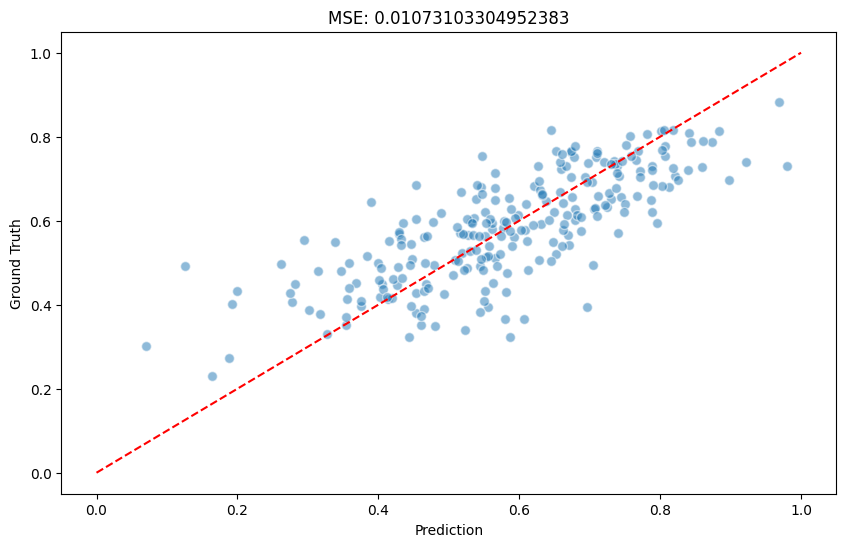

In [10]:
# XGBoost parameters
params = {
    'learning_rate': 0.1,    'n_estimators': 100,    'max_depth': 6,    'min_child_weight': 1,    'gamma': 0,
    'subsample': 1,    'colsample_bytree': 0.8,    'reg_lambda': 1,    'reg_alpha': 0,    'objective': 'reg:squarederror',
    'random_state': 42,    'device':'cuda',    'tree_method':'hist',    # 'enable_categorical':True
}

# INPUT - select feature bundles to include here
feature_names = image_feature_names + OOKLA_feature_names + nightlight_feature_names + OSM_feature_names

# XGBoost model definition and fitting
model_xgb_base = xgb.XGBRegressor(**params)
model_xgb_base.fit(pd.concat([X_train_img,X_val_img],axis=0)[feature_names], np.hstack([y_train,y_val]))

# Evaluation on test set
model_xgb_base.set_params(device="cpu") # To prevent warning messages of model and array residing on different devices
pred = model_xgb_base.predict(X_test_img[feature_names])
mse = mean_squared_error(y_test,pred)
print('Testing performance')
print(f'MSE: {mse:.4f}')

# Plot evaluation results
fig, ax = plt.subplots(1,1,figsize=(10, 6))
ax.scatter(y_test, pred, alpha=0.5, edgecolors='w', s=50)
ax.plot([0,1], [0,1], color='red', linestyle='--', label='Ideal Line')
ax.set_title(f'True Labels vs. Predictions, MSE: {mse}')
ax.set_title(f'MSE: {mse}')
ax.set_xlabel('Prediction')
ax.set_ylabel('Ground Truth');

Compared to the full ViT model in the previous section, we see marked improvement in model performance, both in the MSE score (0.011 compared to 0.014 in the full ViT model) as well as in predictive performance along the lower range of the targets &ndash; lower range data are no longer overestimated.

To perform feature selection, we simply train a separate XGBoost model for each combination of the different feature types, i.e. OOKLA, nightlight, image and OSM. We record MSE for all feature combinations in `df_score` below.

In [11]:
all_feature_groups = {'OOKLA':OOKLA_feature_names,
                      'nightlight':nightlight_feature_names,
                      'image':image_feature_names,
                      'OSM':OSM_feature_names}

# Generate all possible combinations of the items
combinations = []
for r in range(1, len(all_feature_groups) + 1):
    for combination in itertools.combinations(all_feature_groups.keys(), r):
        # Create a dictionary to represent the row
        row = {'OOKLA':0, 'nightlight':0, 'image':0, 'OSM':0}
        combined_list = []
        
        for item in combination:
            row[item] = 1  # Mark the presence of this list
            combined_list.extend(all_feature_groups[item])  # Concatenate the lists
        
        # Add a label for the y-tick
        row['Label'] = ','.join(combination)
        
        row['feature_names'] = combined_list  # Store the combined list as well
        combinations.append(row)

df_score = pd.DataFrame(combinations)
df_score['MSE'] = 0

In [12]:
# XGBoost parameters
params = {
    'learning_rate': 0.1,    'n_estimators': 100,    'max_depth': 6,    'min_child_weight': 1,    'gamma': 0,
    'subsample': 1,    'colsample_bytree': 0.8,    'reg_lambda': 1,    'reg_alpha': 0,    'objective': 'reg:squarederror',
    'random_state': 42,    'device':'cuda',    'tree_method':'hist',    # 'enable_categorical':True
}

# Fit and evaluate on every feature combo
for i, feature_names in enumerate(df_score['feature_names']):
    model_xgb_base = xgb.XGBRegressor(**params)
    # model_xgb_base.fit(X_trainval_img[feature_names], y_trainval)
    model_xgb_base.fit(pd.concat([X_train_img,X_val_img],axis=0)[feature_names], np.hstack([y_train,y_val]))
    
    model_xgb_base.set_params(device="cpu") # To prevent warning messages of model and array residing on different devices
    pred = model_xgb_base.predict(X_test_img[feature_names])
    
    mse = mean_squared_error(y_test,pred)
    df_score.loc[i,'MSE'] = mse

/tmp/ipykernel_27012/905784050.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.011853043921291828' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_score.loc[i,'MSE'] = mse


We then compare the MSE scores for combinations of interest.

Text(0.5, 1.0, 'MSE for Different Feature Combinations')

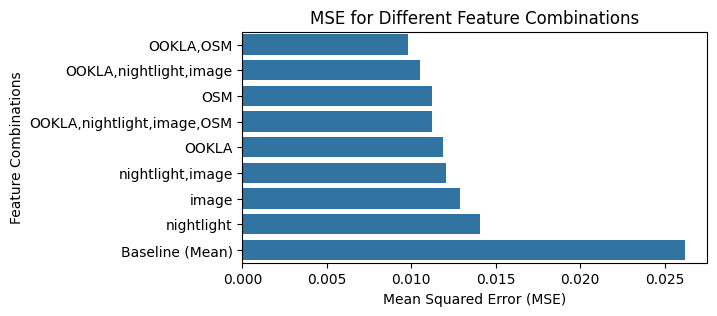

In [13]:
fig, ax = plt.subplots(1,1,figsize=(6,3))
df_plot = df_score.drop(columns=['OOKLA','nightlight','image','OSM','feature_names']).set_index('Label')
df_plot = df_plot.loc[['OOKLA,nightlight,image,OSM','nightlight,image','OOKLA,OSM','OOKLA,nightlight,image','image','OOKLA','nightlight','OSM']]
df_plot = df_plot.sort_values('MSE')
df_plot.loc['Baseline (Mean)','MSE'] = mean_squared_error(np.hstack([y_train,y_val]),
                                                   np.hstack([y_train,y_val]).mean()*np.ones(len(np.hstack([y_train,y_val])))) # Mean prediction as contrived baseline, hehe
sns.barplot(df_plot, x='MSE', y=df_plot.index, orient='h',ax=ax)
ax.set_xlabel('Mean Squared Error (MSE)')
ax.set_ylabel('Feature Combinations')
ax.set_title('MSE for Different Feature Combinations')
# ax.set_xlim([0.004,0.030])


We make a few observations:
1. All selected features are predictive, when compared to the baseline.
2. The feature groups in order of importance are OSM, OOKLA, image, and finally nightlight.
3. As OSM is a community-driven project, information may be scarce or outdated in regions with lower community contribution. On the other hand, nightlight, daytime satellite images, and OOKLA data have worldwide coverage. Using just these feature groups three show good results nonetheless.

We save two models for future use. One with all features, the other with only satellite data, i.e. daytime satellite images and nightlight.

In [16]:
# Saving all feature model
data_path = 'data/'
feature_names = image_feature_names + OOKLA_feature_names + nightlight_feature_names + OSM_feature_names
model_xgb_base = xgb.XGBRegressor(**params)
model_xgb_base.fit(pd.concat([X_train_img,X_val_img,X_test_img],axis=0)[feature_names],
                   np.hstack([y_train,y_val,y_test]))
with open(os.path.join(data_path,'model_xgb_all.pkl'), 'wb') as f:
    pickle.dump(model_xgb_base, f)

# Saving satellit feature + OOKLA model
feature_names = image_feature_names + OOKLA_feature_names + nightlight_feature_names
model_xgb_base = xgb.XGBRegressor(**params)
model_xgb_base.fit(pd.concat([X_train_img,X_val_img,X_test_img],axis=0)[feature_names],
                   np.hstack([y_train,y_val,y_test]))
with open(os.path.join(data_path,'model_xgb_no_OSM.pkl'), 'wb') as f:
    pickle.dump(model_xgb_base, f)

### ViT (Nightlight Trained) Feature Extractor + XGBoost

__Satellite data__:

Satellite derived night time luminosity data (nightlights) have long been used to estimate economic activity and development. A 2016 Science article extends this methodology by using computer vision models trained on predicting nightlight values from daytime satellite images as _feature extractors_ instead <a name="cite_jean2016"></a>[<sup>[1]</sup>](#cite_note-1). Based on their findings, this approach demonstrates superior predictive performance of poverty levels. Their code is open-source and accessible [here](https://github.com/nealjean/predicting-poverty).

This approach makes use of high resolution images at 2.5m per pixel. The [ThinkingMachines approach](https://github.com/thinkingmachines/ph-poverty-mapping/tree/master) replicates this work for the Philippines using an even higher resolution at 1m per pixel. However, high resolution satellite images are often costly, which may hinder the application of such methods for smaller/bootstrapped organizations. Please refer to the sister notebook `data_sat_img_map_feat.ipynb` for a discussion of the different approaches for acquiring daytime satellite images. Here, we explore the use of freely available low resolution (at 10m per pixel), low-bit images and assess the viability of their application for this purpose

<a name="cite_note-1"></a>1. [](#cite_jean2016) Jean, N., Burke, M., Xie, M., Davis, W. M., Lobell, D. B., & Ermon, S. (2016). Combining satellite imagery and machine learning to predict poverty. Science, 353(6301), 790-794..

#### Train Feature Extractor Model to Predict Nightlight

First, we train a computer vision NN to predict nightlight. Since this is a feature extractor, we can train the model on the whole country, not just DHS locations. First, we define a NN architecture, which is achieved simply by adding a regression head to the ViT pre-trained model.

In [5]:
class VitBaseForRegression3(nn.Module):
    def __init__(self, base_model):
        super(VitBaseForRegression3, self).__init__()
        self.backbone = base_model
        
        # Add a regression head
        self.fc = nn.Sequential(
            nn.BatchNorm1d(base_model.num_features),  # Batch normalization
            nn.Linear(base_model.num_features, 512),  # First layer
            nn.BatchNorm1d(512),                      # Batch normalization
            nn.ReLU(),                                # Activation function
            nn.Dropout(0.3),                          # Dropout for regularization
            nn.Linear(512, 1),                        # Output layer
        )
        
        # Freeze the weights of the backbone
        for param in self.backbone.parameters():
            param.requires_grad = False
            
    def forward(self, x):
        features = self.backbone(x)
        outputs = self.fc(features)
        return outputs

model_base = timm.create_model(
    'vit_base_patch16_224.dino',
    pretrained=True,
    num_classes=0,  # remove classifier nn.Linear
)

# Get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model_base)
model_transforms = timm.data.create_transform(**data_config, is_training=False)

# Create regression model
model_reg = VitBaseForRegression3(model_base)

# Use GPU training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_reg.to(device);

criterion = nn.MSELoss()
optimizer = optim.SGD(model_reg.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


We define the transforms needed for data augmentation as usual, ensuring the ViT-required transforms given by `model_transforms` is included.

In [6]:
# Transform
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),                        # Resize to 224x224
    transforms.RandomHorizontalFlip(p=0.5),               # Randomly flip horizontally with a probability of 0.5
    transforms.RandomVerticalFlip(p=0.5),                 # Randomly flip vertically with a probability of 0.5
    transforms.RandomRotation(degrees=30),                # Randomly rotate within the range [-30, 30] degrees
    transforms.RandomAffine(degrees=0, shear=10),         # Apply shearing with a range of [-10, 10] degrees
    # transforms.ToTensor(),                                # Convert the image to a tensor
    model_transforms
])

val_transform = model_transforms
test_transform = model_transforms

data_transforms = {
    'train': train_transform,
    'val': val_transform,
    'test': test_transform
}

The nightlight value used is `avg_rad_min`, which represents the minimum average radiance, found to be better correlated with wealth levels. This is used as the target for training.

In [7]:
# Load target information
target_path = 'data'
df_target_raw = pd.read_csv(os.path.join(target_path,'X_2022_grid.csv'))\
    .rename(columns={'avg_rad_min':'target'}).drop(columns=['Unnamed: 0'])
df_target_raw['filename'] = pd.Series(df_target_raw.index).map(lambda x: 'map_'+str(x)+'.tif')
df_target_raw = df_target_raw[['filename','target']]
df_target_raw = df_target_raw.astype({'target':'float32'})

We reuse the`RegressionDataset2` definition from the previous section and load the daytime satellite images acquired for the whole country (detailed in `data_sat_img_map_feat.ipynb`).

In [10]:
# Load the full dataset
df_target = df_target_raw.copy()
image_folder = 'data/daysat/2022_grid/'

# Perform train test split
ind_training, ind_test = train_test_split(df_target.index, test_size=0.1, random_state=42)
ind_train, ind_val = train_test_split(ind_training, test_size=0.1, random_state=42)

# Create datasets
train_dataset = RegressionDataset2(image_folder=image_folder, targets_df=df_target.loc[ind_train,:].reset_index(drop=True),transform=data_transforms['train'])
val_dataset = RegressionDataset2(image_folder=image_folder, targets_df=df_target.loc[ind_val,:].reset_index(drop=True),transform=data_transforms['val'])
test_dataset = RegressionDataset2(image_folder=image_folder, targets_df=df_target.loc[ind_test,:].reset_index(drop=True),transform=data_transforms['test'])

# Determine the sizes for the different datasets
total_size, train_val_size, train_size, val_size, test_size = len(df_target), len(ind_train) + len(ind_val), len(ind_train), len(ind_val), len(ind_test)
dataset_sizes = {'train':train_size, 'val':val_size, 'test': test_size}

# Create DataLoader instances
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=16,drop_last=False),
    'val': DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=16,drop_last=False),
    'test': DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=16,drop_last=False)
}

We define `train_model3` function for training.

In [12]:
from tqdm import tqdm
import time
import torch
import pandas as pd
import numpy as np
import os
from tempfile import TemporaryDirectory

# Training code
def train_model3(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes,
                num_epochs=25, verbose=0, plot_curves=True):
    since = time.time()
    df = pd.DataFrame({'train': np.zeros([num_epochs]), 'val': np.zeros([num_epochs])})

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_loss = 1e10

        for epoch in range(num_epochs):
            if verbose == 1: # and epoch % 1 == 0:
                print(f'Epoch {epoch}/{num_epochs - 1}')
                print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()  # Set model to evaluate mode

                running_loss = 0.0

                # Iterate over data with progress bar
                with tqdm(dataloaders[phase], desc=f'{phase.capitalize()} Epoch {epoch + 1}/{num_epochs}', unit='batch') as pbar:
                    for inputs, labels in pbar:
                        inputs = inputs.to(device)
                        labels = labels.to(device)

                        # zero the parameter gradients
                        optimizer.zero_grad()

                        # forward
                        # track history if only in train
                        with torch.set_grad_enabled(phase == 'train'):
                            outputs = model(inputs).squeeze()
                            loss = criterion(outputs, labels.squeeze())

                            # backward + optimize only if in training phase
                            if phase == 'train':
                                loss.backward()
                                optimizer.step()

                        # statistics
                        running_loss += loss.item() * inputs.size(0)

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                if verbose == 1: # and epoch%20==0:
                    print(f'{phase} Loss: {epoch_loss:.4f}')
                df.loc[epoch, phase] = epoch_loss

                # Update progress bar with the loss
                pbar.set_postfix({'Loss': f'{epoch_loss:.4f}'})

                # deep copy the model
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                    torch.save(model.state_dict(), best_model_params_path)

            if verbose == 1: # and epoch % 1 == 0:
                print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

        if plot_curves:
            df.plot()

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model, df


In [14]:
# Train model
model_reg, df = train_model3(model_reg, criterion, optimizer, exp_lr_scheduler,dataloaders, dataset_sizes,
                       num_epochs=30,verbose=1,plot_curves=False)

Epoch 0/29
----------


Train Epoch 1/30: 100%|████████████████████| 588/588 [01:05<00:00,  9.04batch/s]


train Loss: 0.5187


Val Epoch 1/30: 100%|████████████████████████| 66/66 [00:07<00:00,  8.72batch/s]


val Loss: 0.5681

Epoch 1/29
----------


Train Epoch 2/30: 100%|████████████████████| 588/588 [01:05<00:00,  9.03batch/s]


train Loss: 0.4278


Val Epoch 2/30: 100%|████████████████████████| 66/66 [00:07<00:00,  8.76batch/s]


val Loss: 0.5147

Epoch 2/29
----------


Train Epoch 3/30: 100%|████████████████████| 588/588 [01:05<00:00,  9.03batch/s]


train Loss: 0.4041


Val Epoch 3/30: 100%|████████████████████████| 66/66 [00:07<00:00,  8.70batch/s]


val Loss: 0.3491

Epoch 3/29
----------


Train Epoch 4/30: 100%|████████████████████| 588/588 [01:05<00:00,  9.04batch/s]


train Loss: 0.3696


Val Epoch 4/30: 100%|████████████████████████| 66/66 [00:07<00:00,  8.60batch/s]


val Loss: 0.3392

Epoch 4/29
----------


Train Epoch 5/30: 100%|████████████████████| 588/588 [01:05<00:00,  9.04batch/s]


train Loss: 0.3444


Val Epoch 5/30: 100%|████████████████████████| 66/66 [00:07<00:00,  8.65batch/s]


val Loss: 0.3253

Epoch 5/29
----------


Train Epoch 6/30: 100%|████████████████████| 588/588 [01:05<00:00,  9.04batch/s]


train Loss: 0.3368


Val Epoch 6/30: 100%|████████████████████████| 66/66 [00:07<00:00,  8.74batch/s]


val Loss: 0.4553

Epoch 6/29
----------


Train Epoch 7/30: 100%|████████████████████| 588/588 [01:05<00:00,  9.04batch/s]


train Loss: 0.3482


Val Epoch 7/30: 100%|████████████████████████| 66/66 [00:07<00:00,  8.69batch/s]


val Loss: 0.3372

Epoch 7/29
----------


Train Epoch 8/30: 100%|████████████████████| 588/588 [01:05<00:00,  9.04batch/s]


train Loss: 0.3222


Val Epoch 8/30: 100%|████████████████████████| 66/66 [00:07<00:00,  8.66batch/s]


val Loss: 0.3122

Epoch 8/29
----------


Train Epoch 9/30: 100%|████████████████████| 588/588 [01:05<00:00,  9.04batch/s]


train Loss: 0.3373


Val Epoch 9/30: 100%|████████████████████████| 66/66 [00:07<00:00,  8.76batch/s]


val Loss: 0.3274

Epoch 9/29
----------


Train Epoch 10/30: 100%|███████████████████| 588/588 [01:05<00:00,  9.04batch/s]


train Loss: 0.3116


Val Epoch 10/30: 100%|███████████████████████| 66/66 [00:07<00:00,  8.75batch/s]


val Loss: 0.3005

Epoch 10/29
----------


Train Epoch 11/30: 100%|███████████████████| 588/588 [01:04<00:00,  9.05batch/s]


train Loss: 0.2623


Val Epoch 11/30: 100%|███████████████████████| 66/66 [00:07<00:00,  8.67batch/s]


val Loss: 0.3096

Epoch 11/29
----------


Train Epoch 12/30: 100%|███████████████████| 588/588 [01:05<00:00,  9.04batch/s]


train Loss: 0.2791


Val Epoch 12/30: 100%|███████████████████████| 66/66 [00:07<00:00,  8.73batch/s]


val Loss: 0.2891

Epoch 12/29
----------


Train Epoch 13/30: 100%|███████████████████| 588/588 [01:05<00:00,  9.02batch/s]


train Loss: 0.2675


Val Epoch 13/30: 100%|███████████████████████| 66/66 [00:07<00:00,  8.77batch/s]


val Loss: 0.3048

Epoch 13/29
----------


Train Epoch 14/30: 100%|███████████████████| 588/588 [01:05<00:00,  9.03batch/s]


train Loss: 0.2632


Val Epoch 14/30: 100%|███████████████████████| 66/66 [00:07<00:00,  8.65batch/s]


val Loss: 0.2725

Epoch 14/29
----------


Train Epoch 15/30: 100%|███████████████████| 588/588 [01:05<00:00,  9.03batch/s]


train Loss: 0.2562


Val Epoch 15/30: 100%|███████████████████████| 66/66 [00:07<00:00,  8.65batch/s]


val Loss: 0.3027

Epoch 15/29
----------


Train Epoch 16/30: 100%|███████████████████| 588/588 [01:05<00:00,  9.03batch/s]


train Loss: 0.2646


Val Epoch 16/30: 100%|███████████████████████| 66/66 [00:07<00:00,  8.64batch/s]


val Loss: 0.3271

Epoch 16/29
----------


Train Epoch 17/30: 100%|███████████████████| 588/588 [01:05<00:00,  9.04batch/s]


train Loss: 0.2578


Val Epoch 17/30: 100%|███████████████████████| 66/66 [00:07<00:00,  8.63batch/s]


val Loss: 0.2716

Epoch 17/29
----------


Train Epoch 18/30: 100%|███████████████████| 588/588 [01:05<00:00,  9.02batch/s]


train Loss: 0.2552


Val Epoch 18/30: 100%|███████████████████████| 66/66 [00:07<00:00,  8.66batch/s]


val Loss: 0.3344

Epoch 18/29
----------


Train Epoch 19/30: 100%|███████████████████| 588/588 [01:05<00:00,  9.04batch/s]


train Loss: 0.2509


Val Epoch 19/30: 100%|███████████████████████| 66/66 [00:07<00:00,  8.76batch/s]


val Loss: 0.2615

Epoch 19/29
----------


Train Epoch 20/30: 100%|███████████████████| 588/588 [01:05<00:00,  9.05batch/s]


train Loss: 0.2561


Val Epoch 20/30: 100%|███████████████████████| 66/66 [00:07<00:00,  8.66batch/s]


val Loss: 0.2680

Epoch 20/29
----------


Train Epoch 21/30: 100%|███████████████████| 588/588 [01:05<00:00,  9.04batch/s]


train Loss: 0.2511


Val Epoch 21/30: 100%|███████████████████████| 66/66 [00:07<00:00,  8.61batch/s]


val Loss: 0.2621

Epoch 21/29
----------


Train Epoch 22/30: 100%|███████████████████| 588/588 [01:05<00:00,  9.04batch/s]


train Loss: 0.2321


Val Epoch 22/30: 100%|███████████████████████| 66/66 [00:07<00:00,  8.78batch/s]


val Loss: 0.2527

Epoch 22/29
----------


Train Epoch 23/30: 100%|███████████████████| 588/588 [01:05<00:00,  9.03batch/s]


train Loss: 0.2345


Val Epoch 23/30: 100%|███████████████████████| 66/66 [00:07<00:00,  8.69batch/s]


val Loss: 0.2510

Epoch 23/29
----------


Train Epoch 24/30: 100%|███████████████████| 588/588 [01:05<00:00,  9.04batch/s]


train Loss: 0.2284


Val Epoch 24/30: 100%|███████████████████████| 66/66 [00:07<00:00,  8.64batch/s]


val Loss: 0.2561

Epoch 24/29
----------


Train Epoch 25/30: 100%|███████████████████| 588/588 [01:05<00:00,  9.02batch/s]


train Loss: 0.2310


Val Epoch 25/30: 100%|███████████████████████| 66/66 [00:07<00:00,  8.68batch/s]


val Loss: 0.2575

Epoch 25/29
----------


Train Epoch 26/30: 100%|███████████████████| 588/588 [01:05<00:00,  9.04batch/s]


train Loss: 0.2217


Val Epoch 26/30: 100%|███████████████████████| 66/66 [00:07<00:00,  8.76batch/s]


val Loss: 0.2486

Epoch 26/29
----------


Train Epoch 27/30: 100%|███████████████████| 588/588 [01:04<00:00,  9.05batch/s]


train Loss: 0.2243


Val Epoch 27/30: 100%|███████████████████████| 66/66 [00:07<00:00,  8.62batch/s]


val Loss: 0.2500

Epoch 27/29
----------


Train Epoch 28/30: 100%|███████████████████| 588/588 [01:05<00:00,  9.04batch/s]


train Loss: 0.2346


Val Epoch 28/30: 100%|███████████████████████| 66/66 [00:07<00:00,  8.63batch/s]


val Loss: 0.2749

Epoch 28/29
----------


Train Epoch 29/30: 100%|███████████████████| 588/588 [01:05<00:00,  9.03batch/s]


train Loss: 0.2326


Val Epoch 29/30: 100%|███████████████████████| 66/66 [00:07<00:00,  8.78batch/s]


val Loss: 0.2449

Epoch 29/29
----------


Train Epoch 30/30: 100%|███████████████████| 588/588 [01:05<00:00,  9.04batch/s]


train Loss: 0.2273


Val Epoch 30/30: 100%|███████████████████████| 66/66 [00:07<00:00,  8.75batch/s]


val Loss: 0.2421

Training complete in 36m 24s


Visualizing the loss curves.

<Axes: >

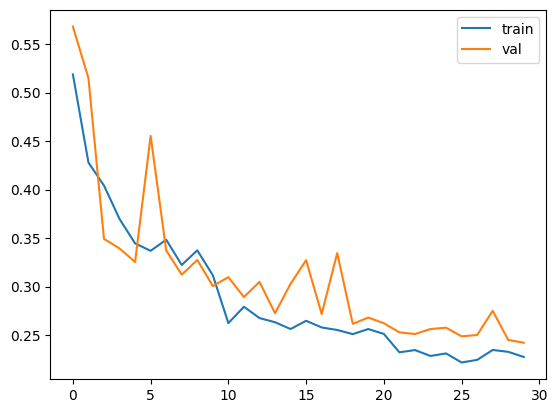

In [15]:
df.plot()

Checking test performance of model in predicting nightlight from daytime satellite images.

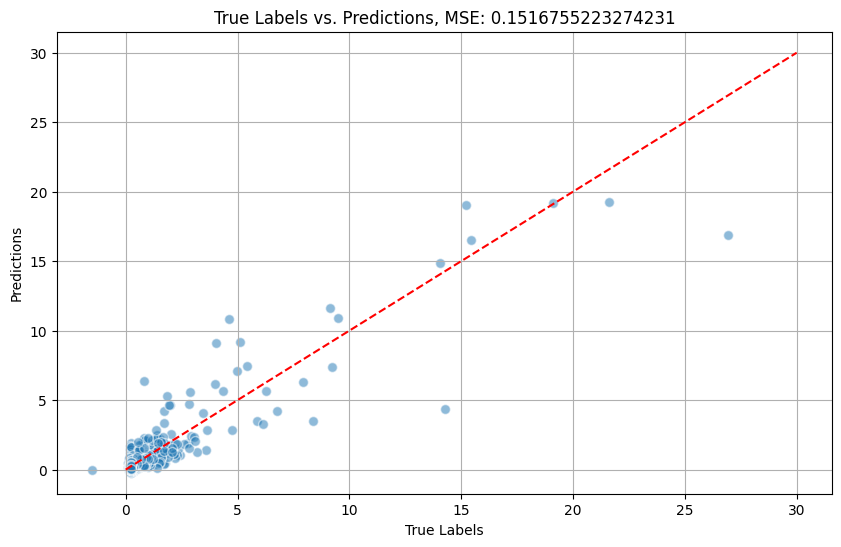

In [16]:
# Initialize lists to store the outputs and labels
all_outputs = []
all_labels = []

model_reg.eval()  # Set the model to evaluation mode

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)  # Ensure labels are also on the correct device
        outputs = model_reg(inputs)

        # Collect outputs and labels
        all_outputs.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate all collected outputs and labels
all_outputs = np.concatenate(all_outputs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Plot true labels vs. predictions
plt.figure(figsize=(10, 6))
plt.scatter(all_labels, all_outputs, alpha=0.5, edgecolors='w', s=50)
plt.plot([0,30], [0,30], color='red', linestyle='--', label='Ideal Line')

mse = mean_squared_error(all_labels, all_outputs)

plt.xlabel('True Labels')
plt.ylabel('Predictions')
plt.title(f'True Labels vs. Predictions, MSE: {mse}')
plt.grid(True)
# plt.ylim([0,1])

Checking test performance of model in predicting nightlight from daytime satellite images for the DHS data points. We observe a large drop in performance, possibly due to over-representation of high nightlight regions amongst DHS datapoints.

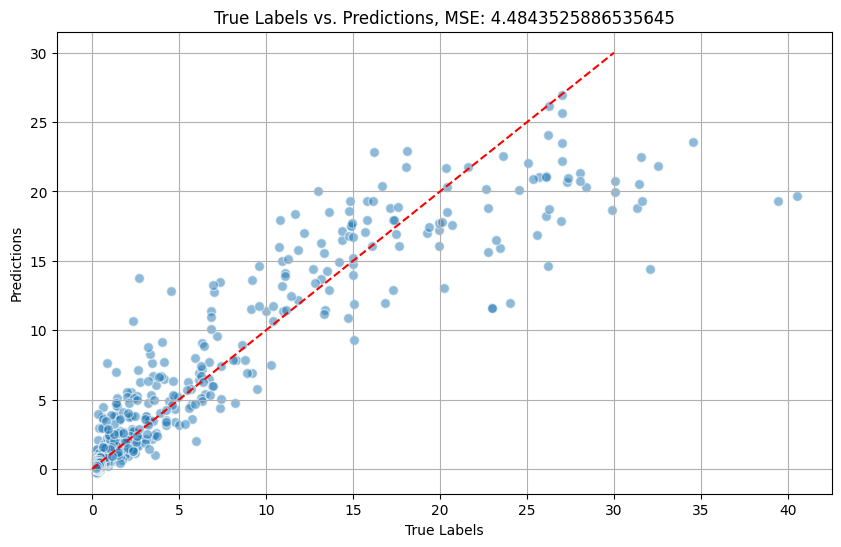

In [18]:
# get features for dhs clusters
dhs_path = 'data'
df_dhs = pd.read_csv(os.path.join(dhs_path,'X.csv'))\
    .rename(columns={'avg_rad_min':'target'})
df_dhs['filename'] = df_dhs['DHSCLUST'].map(lambda x: 'map_'+str(x-1)+'.tif')
df_dhs = df_dhs[['filename','target']]
df_dhs = df_dhs.astype({'target':'float32'})

# Load the full dataset
image_folder = 'data/daysat/2022/'

# Create datasets
test_dataset = RegressionDataset2(image_folder=image_folder, targets_df=df_dhs,transform=data_transforms['test'])

# Create DataLoader instances
dataloaders = {
    'test': DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=16,drop_last=False)
}

# Initialize lists to store the outputs and labels
all_outputs = []
all_labels = []

model_reg.eval()  # Set the model to evaluation mode

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)  # Ensure labels are also on the correct device
        outputs = model_reg(inputs)

        # Collect outputs and labels
        all_outputs.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate all collected outputs and labels
all_outputs = np.concatenate(all_outputs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Plot true labels vs. predictions
plt.figure(figsize=(10, 6))
plt.scatter(all_labels, all_outputs, alpha=0.5, edgecolors='w', s=50)
plt.plot([0,30], [0,30], color='red', linestyle='--', label='Ideal Line')

mse = mean_squared_error(all_labels, all_outputs)

plt.xlabel('True Labels')
plt.ylabel('Predictions')
plt.title(f'True Labels vs. Predictions, MSE: {mse}')
plt.grid(True)
# plt.ylim([0,1])

We use the model to extract features from the day time satellite images for training later.

In [22]:
# Set layer to extract values from
return_nodes = {
    "fc.4": "lin_out"
}
model_reg_extractor = create_feature_extractor(model_reg, return_nodes=return_nodes)
model_reg_extractor.eval()  # Set the model to evaluation mode

all_outputs = []
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        outputs = model_reg_extractor(inputs)
        all_outputs.append(outputs['lin_out'].squeeze().cpu().numpy())
test_img_feat = np.concatenate(all_outputs, axis=0)

with open(os.path.join(dhs_path,'img_feat_dhs_2022_fc4.pkl'),'wb') as f:
    pickle.dump(test_img_feat,f)

Saving the model for use later

In [20]:
torch.save({
    'model_state_dict': model_reg.state_dict(),
    'model_class': model_reg.__class__,
    'model_args': model_reg.args if hasattr(model_reg, 'args') else None,  # Save any arguments used to initialize the model
}, os.path.join(dhs_path,'model_reg_nl.pth'))


#### Train XGBoost Model using Exracted Features

We perform the usual data loading, train test split, and scaling.

In [62]:
# Load data
data_path = 'data'
y = pd.read_csv(os.path.join(data_path,'y.csv'))\
    .rename(columns={'Wealth_Index':'target'})\
    .drop(columns=['DHSCLUST'])
y = y.astype({'target':'float32'})
X = pd.read_csv(os.path.join(data_path,'X.csv')).drop(columns=['DHSCLUST'])
X.dropna(inplace=True)

# Perform train test split
ind_training, ind_test = train_test_split(X.index, test_size=0.2, random_state=42)
ind_train, ind_val = train_test_split(ind_training, test_size=0.2, random_state=42)

X_train = X.loc[ind_train,:]
X_val = X.loc[ind_val,:]
X_test = X.loc[ind_test,:]

y_train = y.loc[ind_train,:]
y_val = y.loc[ind_val,:]
y_test = y.loc[ind_test,:]

# MinMaxScale to target
scaler = MinMaxScaler()
scaler.fit(pd.concat([y_train,y_val],axis=0))
y_train = scaler.transform(y_train)
y_val = scaler.transform(y_val)
y_test = scaler.transform(y_test)

We load the features previously extracted from daytime satellite images and extract the top 50 PCA components to construct the model features.

In [24]:
# Get image features
with open(os.path.join(data_path,'img_feat_dhs_2022_fc4.pkl'),'rb') as f:
    img_feat = pickle.load(f)

train_img_feat = img_feat[ind_train,:]
val_img_feat = img_feat[ind_val,:]
test_img_feat = img_feat[ind_test,:]

# Scale before PCA
scaler_img = StandardScaler()
scaler_img.fit(np.vstack([train_img_feat,val_img_feat]))
train_img_feat = scaler_img.transform(train_img_feat)
val_img_feat = scaler_img.transform(val_img_feat)
test_img_feat = scaler_img.transform(test_img_feat)

# Perform PCA
pca_img = PCA(n_components=50)
pca_img.fit(np.vstack([train_img_feat,val_img_feat]))
print(np.sum(pca_img.explained_variance_ratio_))
train_img_feat = pca_img.transform(train_img_feat)
val_img_feat = pca_img.transform(val_img_feat)
test_img_feat = pca_img.transform(test_img_feat)

# Get image features
X_train_img = pd.concat([X_train,
                     pd.DataFrame(train_img_feat,
                                  columns=[f'img_{i}' for i in range(train_img_feat.shape[1])],
                                  index=X_train.index)],
                    axis=1)
X_val_img = pd.concat([X_val,
                     pd.DataFrame(val_img_feat,
                                  columns=[f'img_{i}' for i in range(val_img_feat.shape[1])],
                                  index=X_val.index)],
                    axis=1)
X_test_img = pd.concat([X_test,
                     pd.DataFrame(test_img_feat,
                                  columns=[f'img_{i}' for i in range(test_img_feat.shape[1])],
                                  index=X_test.index)],
                    axis=1)

0.6812744


In [28]:
X_train_img.shape, X_val_img.shape

((783, 396), (196, 396))

As before, we first train using all feature groups.

Testing performance
MSE: 0.0109


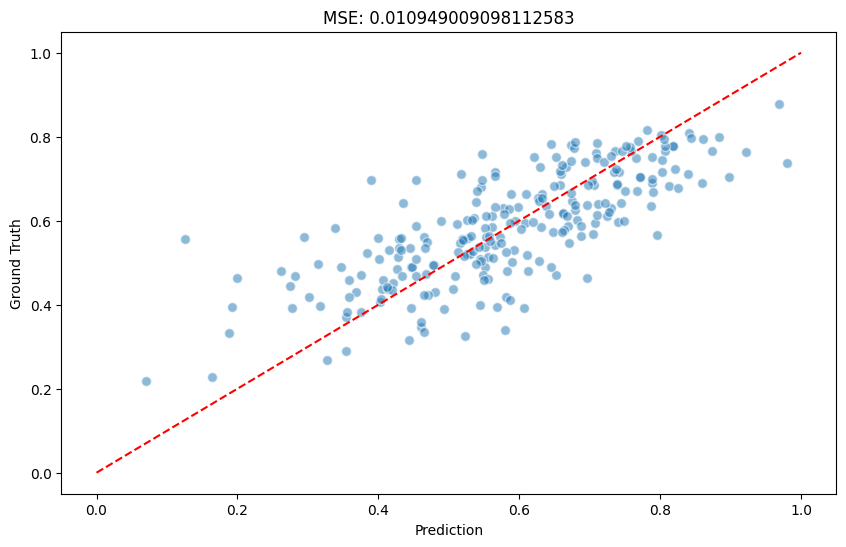

In [33]:
# XGBoost parameters
params = {
    'learning_rate': 0.1,    'n_estimators': 100,    'max_depth': 6,    'min_child_weight': 1,    'gamma': 0,
    'subsample': 1,    'colsample_bytree': 0.8,    'reg_lambda': 1,    'reg_alpha': 0,    'objective': 'reg:squarederror',
    'random_state': 42,    'device':'cuda',    'tree_method':'hist',    # 'enable_categorical':True
}

# INPUT - select feature bundles to include here
feature_names = image_feature_names + OOKLA_feature_names + nightlight_feature_names + OSM_feature_names

# XGBoost model definition and fitting
model_xgb_base = xgb.XGBRegressor(**params)
model_xgb_base.fit(pd.concat([X_train_img,X_val_img],axis=0)[feature_names], np.vstack([y_train,y_val]))

# Evaluation on test set
model_xgb_base.set_params(device="cpu") # To prevent warning messages of model and array residing on different devices
pred = model_xgb_base.predict(X_test_img[feature_names])
mse = mean_squared_error(y_test,pred)
print('Testing performance')
print(f'MSE: {mse:.4f}')

# Plot evaluation results
fig, ax = plt.subplots(1,1,figsize=(10, 6))
ax.scatter(y_test, pred, alpha=0.5, edgecolors='w', s=50)
ax.plot([0,1], [0,1], color='red', linestyle='--', label='Ideal Line')
ax.set_title(f'True Labels vs. Predictions, MSE: {mse}')
ax.set_title(f'MSE: {mse}')
ax.set_xlabel('Prediction')
ax.set_ylabel('Ground Truth');

We then fit multiple XGBoost models with different combinations of feature groups and compile their respective MSE scores.

In [43]:
all_feature_groups = {'OOKLA':OOKLA_feature_names,
                      'nightlight':nightlight_feature_names,
                      'image':image_feature_names,
                      'OSM':OSM_feature_names}

# Generate all possible combinations of the items
combinations = []
for r in range(1, len(all_feature_groups) + 1):
    for combination in itertools.combinations(all_feature_groups.keys(), r):
        # Create a dictionary to represent the row
        row = {'OOKLA':0, 'nightlight':0, 'image':0, 'OSM':0}
        combined_list = []
        
        for item in combination:
            row[item] = 1  # Mark the presence of this list
            combined_list.extend(all_feature_groups[item])  # Concatenate the lists
        
        # Add a label for the y-tick
        row['Label'] = ','.join(combination)
        
        row['feature_names'] = combined_list  # Store the combined list as well
        combinations.append(row)

df_score_nl = pd.DataFrame(combinations)
df_score_nl['MSE'] = 0

In [44]:
# XGBoost parameters
params = {
    'learning_rate': 0.1,    'n_estimators': 100,    'max_depth': 6,    'min_child_weight': 1,    'gamma': 0,
    'subsample': 1,    'colsample_bytree': 0.8,    'reg_lambda': 1,    'reg_alpha': 0,    'objective': 'reg:squarederror',
    'random_state': 42,    'device':'cuda',    'tree_method':'hist',    # 'enable_categorical':True
}

# Fit and evaluate on every feature combo
for i, feature_names in enumerate(df_score_nl['feature_names']):
    model_xgb_base = xgb.XGBRegressor(**params)
    # model_xgb_base.fit(X_trainval_img[feature_names], y_trainval)
    model_xgb_base.fit(pd.concat([X_train_img,X_val_img],axis=0)[feature_names], np.vstack([y_train,y_val]))
    
    model_xgb_base.set_params(device="cpu") # To prevent warning messages of model and array residing on different devices
    pred = model_xgb_base.predict(X_test_img[feature_names])
    
    mse = mean_squared_error(y_test,pred)
    df_score_nl.loc[i,'MSE'] = mse

/tmp/ipykernel_145732/1456432460.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.011853043921291828' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_score_nl.loc[i,'MSE'] = mse


We compare these scores with those from the XGBoost model trained daytime satellite image features extracted directly from ViT, instead of those being trained on nightlight in this section.features

In [60]:
df_score_nl['ViT'] = 'Nightlight Trained'
df_score['ViT'] = 'Regular'
df_score_combined = pd.concat([df_score_nl,df_score],axis=0)


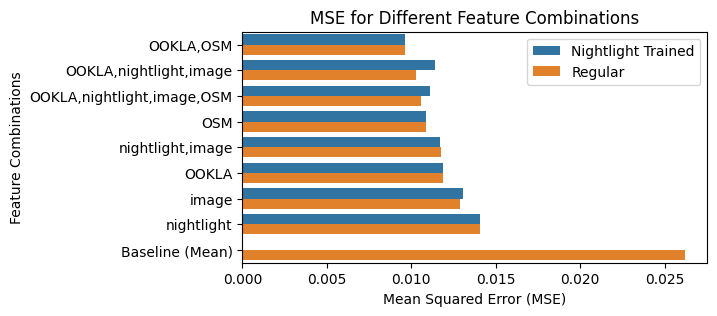

In [67]:
fig, ax = plt.subplots(1,1,figsize=(6,3))
df_plot = df_score_combined.drop(columns=['OOKLA','nightlight','image','OSM','feature_names']).set_index('Label')
df_plot = df_plot.loc[['OOKLA,nightlight,image,OSM','nightlight,image','OOKLA,OSM','OOKLA,nightlight,image','image','OOKLA','nightlight','OSM']]
df_plot = df_plot.sort_values('MSE')
df_plot.loc['Baseline (Mean)','MSE'] = mean_squared_error(np.vstack([y_train,y_val]),
                                                   np.vstack([y_train,y_val]).mean()*np.ones(len(np.vstack([y_train,y_val])))) # Mean prediction as contrived baseline
df_plot.loc['Baseline (Mean)','ViT'] = 'Regular'
sns.barplot(df_plot, x='MSE', hue='ViT', y=df_plot.index, orient='h',ax=ax)
ax.set_xlabel('Mean Squared Error (MSE)')
ax.set_ylabel('Feature Combinations')
ax.set_title('MSE for Different Feature Combinations')
ax.legend(bbox_to_anchor=(1,1))

As shown above, nightlight trained image feature does not seem to have brought any improvement. This could be due to the lower satellite image quality used in this study, as opposed to the higher resolution, higher-bit images used in previous studies.

Moving forward, we opt for the more straightforward approach of directly extracting features using the base ViT model.

## Analysis

We demonstrate the use of these machine learning models on public policy evaluation here.

__The author wishes to emphasize that this is an academic exercise aimed at demonstrating how machine learning approaches can be integrated into policy impact evaluation. The analysis presented is intentionally simplistic, and any conclusions drawn should be considered illustrative rather than definitive.__


We first perform poverty mapping for the entire country. The `map_wealth_index` function loads the trained XGB models predicts the wealth index for each tile. Here, we use ViT as a feature extractor and consider only two XGB models:
1. model trained on all features; and
2. model trained on all but OSM features.

In [48]:
def map_wealth_index(year:int, image_path: Union[str, Path], feature_path:Union[str, Path],
                     transforms_path:Union[str, Path], model_all_path:Union[str, Path],
                     model_no_OSM_path:Union[str, Path], geogrid_path:Union[str, Path]):
    '''
    Loads the required models and input files for wealth index prediction. Returns
    predictions using XGB model trained with all features, and XGB model trained with
    all but the OSM features.
    year: Year of analysis
    image_path: Path to daytime satellite images of the geo tiles/grid
    feature_path: Path to the features, including nightlight, OSM and OOKLA
    transforms_path: Path to pickle file for standard scaler and PCA objects
    model_all_path: Path to pickle file for model trained with all features
    model_no_OSM_path: Path to pickle file for model trained with all features but OSM
    geogrid_path: Path to pickled geopandas dataframe with grid/tile data
    '''

    # Load data and create dummy target df for filenames
    X = pd.read_csv(feature_path)
    X.rename(columns={'Unnamed: 0':'filename'}, inplace=True)
    X['filename'] = X['filename'].map(lambda x: 'map_'+str(x)+'.tif')
    dumm_y = X[['filename']].copy()
    X.drop(columns=['filename'],inplace=True)

    model_base = timm.create_model(
        'vit_base_patch16_224.dino',
        pretrained=True,
        num_classes=0,  # remove classifier nn.Linear
    )

    # Use GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_base.to(device);

    # get model specific transforms (normalization, resize)
    data_config = timm.data.resolve_model_data_config(model_base)
    model_transforms = timm.data.create_transform(**data_config, is_training=False)

    # Create datasets
    pred_dataset = RegressionDataset2(image_folder=image_path,
                                      targets_df=dumm_y,
                                      transform=model_transforms,
                                      is_train=False)

    # Create DataLoader instances
    dataloaders = {
        'pred': DataLoader(pred_dataset, batch_size=64, shuffle=False, num_workers=8),
    }

    # Extract image features
    model_base.eval()  # Set the model to evaluation mode

    # Preallocate memory for the output tensor on GPU
    n_samples = len(pred_dataset)
    output_dim = 768
    pred_img_feat = torch.empty((n_samples, output_dim), dtype=torch.float32, device='cuda')  # Store directly in GPU

    # Perform inference
    start_idx = 0
    with torch.no_grad():
        for i,inputs in enumerate(dataloaders['pred']):
            inputs = inputs.to('cuda')  # Move inputs to GPU
            outputs = model_base(inputs)
            batch_size_actual = inputs.size(0)
            pred_img_feat[start_idx:start_idx + batch_size_actual] = outputs  # Store directly in the preallocated tensor
            start_idx += batch_size_actual  # Update start index for the next batch

    # Move the results to the CPU only once after the loop
    pred_img_feat_cpu = pred_img_feat.cpu().numpy()

    # Scale and PCA
    with open(transforms_path,'rb') as f:
        scaler_img, pca_img = pickle.load(f)
    pred_img_feat = scaler_img.transform(pred_img_feat_cpu)
    pred_img_feat = pca_img.transform(pred_img_feat)

    # Get image features
    X_img = pd.concat([X,
                   pd.DataFrame(pred_img_feat,
                                columns=[f'img_{i}' for i in range(pred_img_feat.shape[1])])],
                                axis=1)
    
    # Load XGB model trained with all features
    with open(model_all_path, 'rb') as f:
        model_xgb_all = pickle.load(f)
    model_xgb_all.set_params(device="cpu") # To prevent warning messages of model and array residing on different devices

    # Making sure column names match model requirements (model trained with 2022 features)
    # Change OOKLA feature names for year
    old_feature_names = X_img.columns
    new_feature_names = [old_name.replace('2022',str(year)) for old_name in old_feature_names]
    feature_name_map = {old_name:new_name for old_name,new_name in zip(old_feature_names,new_feature_names)}
    X_img.rename(columns=feature_name_map)

    # Add/remove features
    features_2022 = list(model_xgb_all.feature_names_in_)
    features_current = list(X_img.columns)
    features_to_add = list(set(features_2022) - set(features_current))
    features_to_drop = list(set(features_current) - set(features_2022))


    if len(features_to_add) != 0:
        for feat in features_to_add:
            X_img[feat] = np.nan
    if len(features_to_drop) != 0:
        X_img.drop(columns=features_to_drop,inplace=True)
    
    # Predict using model
    y_xgb_all = model_xgb_all.predict(X_img[features_2022])
    
    # Load XGB model trained with all features but OSM
    with open(model_no_OSM_path, 'rb') as f:
        model_xgb_no_OSM = pickle.load(f)
    model_xgb_no_OSM.set_params(device="cpu") # To prevent warning messages of model and array residing on different devices
    y_xgb_no_OSM = model_xgb_no_OSM.predict(X_img[model_xgb_no_OSM.feature_names_in_])

    # Load grid/tiles as geopandas dataframe
    with open(geogrid_path, 'rb') as f:
        admin_grids_gdf = pickle.load(f)
    admin_grids_gdf = admin_grids_gdf[['geometry']]

    # Predict wealth index with models
    y_xgb_all = pd.concat([admin_grids_gdf,pd.DataFrame(y_xgb_all,columns=['Wealth_Index'])],axis=1)
    y_xgb_no_OSM = pd.concat([admin_grids_gdf,pd.DataFrame(y_xgb_no_OSM,columns=['Wealth_Index'])],axis=1)

    return y_xgb_all, y_xgb_no_OSM

Visualizing the wealth distribution in 2022.

In [53]:
# INPUT, define paths to saved files for 2022
datapath = "data/"
image_folder = 'daysat/2022_grid/'
feature_csv = 'X_2022_grid.csv'
transforms_filename = 'model_xgb_transforms.pkl'
model_all_filename = 'model_xgb_all.pkl'
model_no_OSM_filename = 'model_xgb_no_OSM.pkl'
geogrid_filename = 'geogrid_2020_HRSL.pkl'

image_path = os.path.join(datapath,image_folder)
feature_path = os.path.join(datapath,feature_csv)
transforms_path = os.path.join(datapath,transforms_filename)
model_all_path = os.path.join(datapath,model_all_filename)
model_no_OSM_path = os.path.join(datapath,model_no_OSM_filename)
geogrid_path = os.path.join(datapath,geogrid_filename)

y_xgb_all_2022, y_xgb_no_OSM_2022 = map_wealth_index(2022,image_path, feature_path,
                                           transforms_path, model_all_path,
                                           model_no_OSM_path, geogrid_path)

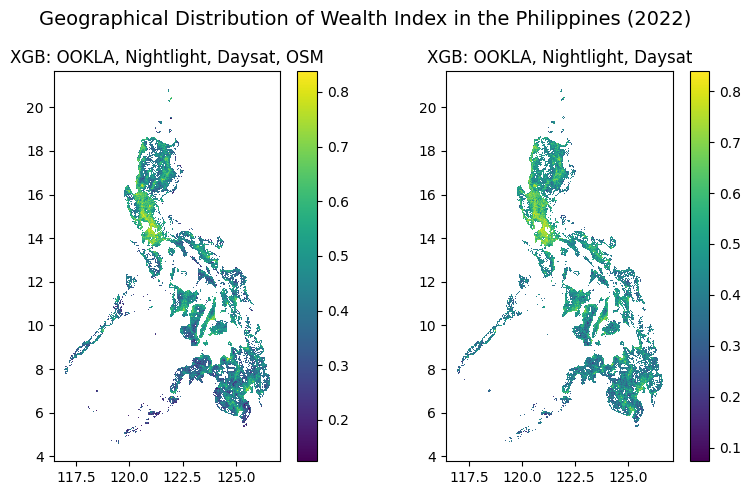

In [54]:
fig, axs = plt.subplots(1,2,figsize=(8,5))
y_xgb_all_2022.plot(column='Wealth_Index', ax=axs[0], legend=True, cmap='viridis')
y_xgb_no_OSM_2022.plot(column='Wealth_Index', ax=axs[1], legend=True, cmap='viridis')

fig.suptitle('Geographical Distribution of Wealth Index in the Philippines (2022)', fontsize=14)
axs[0].set_title('XGB: OOKLA, Nightlight, Daysat, OSM')
axs[1].set_title('XGB: OOKLA, Nightlight, Daysat')
fig.tight_layout()

Getting wealth distribution for 2020, 2021 and 2023.

In [55]:
# INPUT, define paths to saved files for 2020
datapath = "data/"
image_folder = 'daysat/2020_grid/'
feature_csv = 'X_2020_grid.csv'
transforms_filename = 'model_xgb_transforms.pkl'
model_all_filename = 'model_xgb_all.pkl'
model_no_OSM_filename = 'model_xgb_no_OSM.pkl'
geogrid_filename = 'geogrid_2020_HRSL.pkl'

image_path = os.path.join(datapath,image_folder)
feature_path = os.path.join(datapath,feature_csv)
transforms_path = os.path.join(datapath,transforms_filename)
model_all_path = os.path.join(datapath,model_all_filename)
model_no_OSM_path = os.path.join(datapath,model_no_OSM_filename)
geogrid_path = os.path.join(datapath,geogrid_filename)

y_xgb_all_2020, y_xgb_no_OSM_2020 = map_wealth_index(2020,image_path, feature_path,
                                           transforms_path, model_all_path,
                                           model_no_OSM_path, geogrid_path)

# INPUT, define paths to saved files for 2021
datapath = "data/"
image_folder = 'daysat/2021_grid/'
feature_csv = 'X_2021_grid.csv'
transforms_filename = 'model_xgb_transforms.pkl'
model_all_filename = 'model_xgb_all.pkl'
model_no_OSM_filename = 'model_xgb_no_OSM.pkl'
geogrid_filename = 'geogrid_2020_HRSL.pkl'

image_path = os.path.join(datapath,image_folder)
feature_path = os.path.join(datapath,feature_csv)
transforms_path = os.path.join(datapath,transforms_filename)
model_all_path = os.path.join(datapath,model_all_filename)
model_no_OSM_path = os.path.join(datapath,model_no_OSM_filename)
geogrid_path = os.path.join(datapath,geogrid_filename)

y_xgb_all_2021, y_xgb_no_OSM_2021 = map_wealth_index(2021,image_path, feature_path,
                                           transforms_path, model_all_path,
                                           model_no_OSM_path, geogrid_path)

# INPUT, define paths to saved files for 2023
datapath = "data/"
image_folder = 'daysat/2023_grid/'
feature_csv = 'X_2023_grid.csv'
transforms_filename = 'model_xgb_transforms.pkl'
model_all_filename = 'model_xgb_all.pkl'
model_no_OSM_filename = 'model_xgb_no_OSM.pkl'
geogrid_filename = 'geogrid_2020_HRSL.pkl'

image_path = os.path.join(datapath,image_folder)
feature_path = os.path.join(datapath,feature_csv)
transforms_path = os.path.join(datapath,transforms_filename)
model_all_path = os.path.join(datapath,model_all_filename)
model_no_OSM_path = os.path.join(datapath,model_no_OSM_filename)
geogrid_path = os.path.join(datapath,geogrid_filename)

y_xgb_all_2023, y_xgb_no_OSM_2023 = map_wealth_index(2023,image_path, feature_path,
                                           transforms_path, model_all_path,
                                           model_no_OSM_path, geogrid_path)

We compile the values from different years.

In [58]:
# Compile wealth index 2020-2023
y_xgb_all_2020['year'] = 2020
y_xgb_all_2021['year'] = 2021
y_xgb_all_2022['year'] = 2022
y_xgb_all_2023['year'] = 2023

y_all = pd.concat([y_xgb_all_2020,y_xgb_all_2021,y_xgb_all_2022,y_xgb_all_2023],axis=0)

We load the PPPP data and do some pre-processing.

In [191]:
with open('data/processed_pppp_geo_data.pkl','rb') as f:
    all_municipal_dfs,gdf_municipality = pickle.load(f)

# Combine PPPP dataframes and get yearly values.
df_municipality = pd.concat(all_municipal_dfs,axis=0)
df_municipality = df_municipality[['region', 'province', 'municipality','grandtotal','year']]
df_municipality_year = df_municipality.groupby(['region','province','municipality','year']).mean()
df_municipality_year = df_municipality_year.reset_index()
df_municipality_year = df_municipality_year.loc[df_municipality_year['year']<2023,:]
df_municipality_year.rename(columns={'year':'effect_year'},inplace=True)    # Assuming that current year's PPPP efforts will influence the following year's wealth index
df_municipality_year['effect_year'] = df_municipality_year['effect_year'] + 1

# Calculate poor household proportion using 2021 poverty incidence estimate.
gdf_municipality['poor_household_indicator'] = gdf_municipality['population']*gdf_municipality['PI_2021']

# Combine with gdf_municipality to allow pppp_effort calculation
df_municipality_year = gdf_municipality.merge(df_municipality_year, on=['region','province','municipality'],how='inner')
df_municipality_year = df_municipality_year[['region', 'province', 'municipality','grandtotal',
                     'effect_year', 'poor_household_indicator']]
df_municipality_year['pppp_effort'] = df_municipality_year['grandtotal']/df_municipality_year['poor_household_indicator']

We perform geo-processing to get wealth index by municipality by year, assuming uniform population density within each municipality.

In [192]:
# TODO: use HRSL for better accuracy
# Convert to project CRS first for accurate area calculations
y_all = y_all.to_crs(epsg=32651)
gdf_municipality = gdf_municipality.to_crs(epsg=32651)

# Calculate areas
y_all['tile_area'] = y_all.geometry.area                                            # Get original tile area before overlaying
gdf_municipality['municipality_area'] = gdf_municipality.geometry.area              # Get original municipality area before overlaying
intersections = gpd.overlay(y_all,                                                  # Get intersection between two gdfs
                            gdf_municipality,
                            how='intersection')
intersections['intersection_area'] = intersections.geometry.area                    # Get intersection area

# Get weighted wealth index before combining values of tiles within municipality boundaries
intersections['proportion'] = intersections['intersection_area'] / intersections['tile_area']
intersections['weighted_wealth_index'] = intersections['Wealth_Index'] * intersections['proportion']
wealth_index_by_municipality = intersections.groupby(['region','province','municipality','year'])['weighted_wealth_index'].mean()

# Get change in wealth index between each year
wealth_index_by_municipality = wealth_index_by_municipality.reset_index()
wealth_index_by_municipality = wealth_index_by_municipality.sort_values(by=['region','province','municipality', 'year'])
wealth_index_by_municipality['Wealth_Index_Change'] = wealth_index_by_municipality.groupby(['region','province','municipality'])['weighted_wealth_index'].diff()
wealth_index_by_municipality.rename(columns={'year':'effect_year'},inplace=True)

In [193]:
df_pppp_wealth = df_municipality_year.merge(wealth_index_by_municipality,on=['region','province','municipality','effect_year'],how='inner')
df_pppp_wealth = df_pppp_wealth[['region', 'province', 'municipality', 'grandtotal', 'effect_year', 'pppp_effort', 'weighted_wealth_index','Wealth_Index_Change']]
df_pppp_wealth.replace([np.inf, -np.inf], np.nan, inplace=True)
df_pppp_wealth = df_pppp_wealth.dropna()

Finally, we do a quick statistical analysis with linear regression to check the effect of PPPP efforts.

In [233]:
import pandas as pd

df_temp = df_pppp_wealth.copy()

X = df_temp['pppp_effort']
y = df_temp['Wealth_Index_Change']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())


                             OLS Regression Results                            
Dep. Variable:     Wealth_Index_Change   R-squared:                       0.001
Model:                             OLS   Adj. R-squared:                  0.001
Method:                  Least Squares   F-statistic:                     5.815
Date:                 Fri, 13 Sep 2024   Prob (F-statistic):             0.0159
Time:                         16:48:03   Log-Likelihood:                 11388.
No. Observations:                 4863   AIC:                        -2.277e+04
Df Residuals:                     4861   BIC:                        -2.276e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0119      0.000     27

From the linear regression performed above, we see a negative coefficient for PPPP effort, and a p-value that is lower than 0.05, indicating statistical significance. This seems to suggest that PPPP efforts are associated with _increased_ poverty levels. However, We should consider the following when interpreting the results above. This simplistic analysis looks only at PPPP efforts. Other effects, e.g. pandemic, natural disasters, political turmoil, etc, are all likely to have a huge impact on poverty levels, but are completely neglected here. Furthermore, it is possible that PPPP efforts are stepped up precisely because of foreseen hardships due to aforementioned factors.

__The author wishes to emphasize that this is an academic exercise aimed at demonstrating how machine learning approaches can be integrated into policy impact evaluation. The analysis presented is intentionally simplistic, and any conclusions drawn should be considered illustrative rather than definitive.__